# Customer Segmentation

## Table of Content

* [4 Pre-processing](#4) 
* [5 Clustering](#5)
    * [5.1 KMeans](#5.1)
        * [5.1.1 Without Scaling](#5.1.1)
        * [5.1.2 StandardScaler](#5.1.2)
        * [5.1.3 Logarithmic + cubic root transformation](#5.1.3)
        * [5.1.4 Logarithmic + cubic root transformation + StandardScaler](#5.1.4)
    * [5.2 DBSCAN](#5.2)
* [6 Conclusions](#6)

In [441]:
#Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date

from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

%matplotlib inline

## 4 Pre-processing<a id='4'></a>

In [407]:
# Import clean data from data wrangling and EDA
online = pd.read_csv('..\data\online_clean.csv')
online_RFM = pd.read_csv('..\data\online_RFM.csv')

In [408]:
online = online.drop(columns='Unnamed: 0')
online.head()

,Customer ID,Invoice,InvoiceDate,Price,Quantity,StockCode,Country,Description_rev
0,13085,489434,2009-12-01 07:45:00,6.95,12,85048,United Kingdom,15cm christmas glass ball 20 lights
1,13085,489434,2009-12-01 07:45:00,6.75,12,79323P,United Kingdom,pink cherry lights
2,13085,489434,2009-12-01 07:45:00,6.75,12,79323W,United Kingdom,white cherry lights
3,13085,489434,2009-12-01 07:45:00,2.10,48,22041,United Kingdom,"record frame 7"" single size"
4,13085,489434,2009-12-01 07:45:00,1.25,24,21232,United Kingdom,strawberry ceramic trinket box


In [409]:
online_RFM = online_RFM.drop(columns='Unnamed: 0')
online_RFM = online_RFM.rename(columns={'OverallScore': 'RFM_score'})
online_RFM.head()

,Customer ID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,RFM_score,Segment
0,13085,157,2,92,0,1459.46,0,2,Low-Value
1,16714,218,2,114,0,1222.24,0,2,Low-Value
2,17984,144,2,242,0,1152.19,0,2,Low-Value
3,16955,184,2,53,0,1072.06,0,2,Low-Value
4,18037,153,2,33,0,167.42,0,2,Low-Value


In [410]:
# extract recency, frequency, and revenue 
online_RFM = online_RFM[['Customer ID', 'Recency', 'Frequency', 'Revenue']]

In [411]:
# calcuate average price and quantity for each customer
price_quantity = online.groupby('Customer ID').agg({'Price': 'mean', 'Quantity': 'mean'})
price_quantity = price_quantity.reset_index()

In [412]:
# generate dataset for clustering
model_input = price_quantity.merge(online_RFM, on='Customer ID', how='left').drop(columns='Customer ID')
model_input.head()

,Price,Quantity,Recency,Frequency,Revenue
0,12.074468,1.127660,325,47,-51.74
1,2.498063,13.364865,1,222,4921.53
2,3.786275,53.215686,74,51,2019.40
3,8.358833,8.994444,18,180,4404.54
4,3.841176,11.588235,309,17,334.40


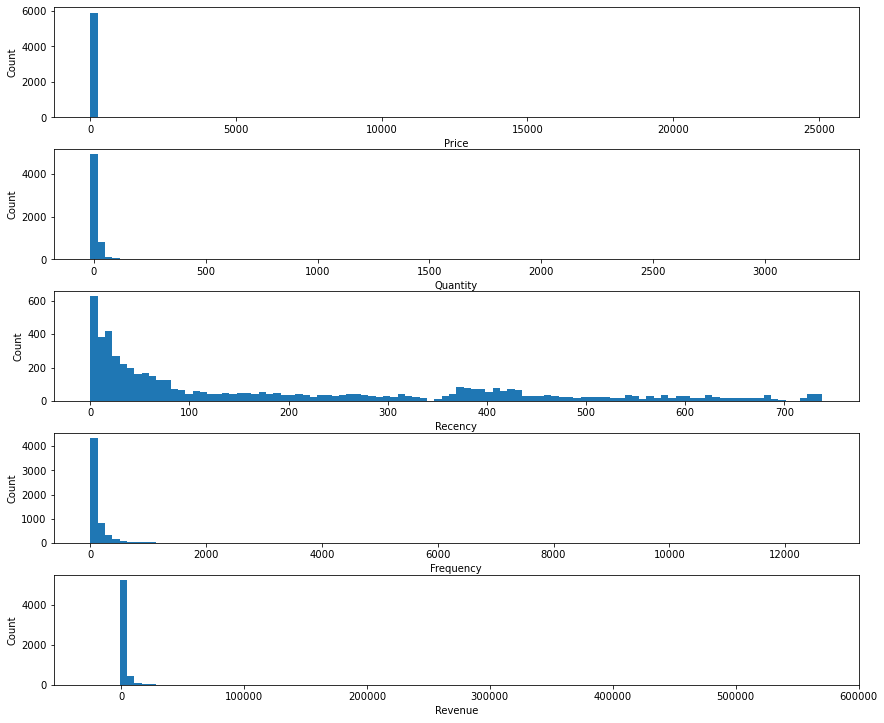

In [377]:
# show the distribution each feature
fig, ax = plt.subplots(5, 1, figsize=(12,10))
fig.tight_layout()

ax[0].hist(model_input['Price'], bins=100)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Count')

ax[1].hist(model_input['Quantity'], bins=100)
ax[1].set_xlabel('Quantity')
ax[1].set_ylabel('Count')

ax[2].hist(model_input['Recency'], bins=100)
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Count')

ax[3].hist(model_input['Frequency'], bins=100)
ax[3].set_xlabel('Frequency')
ax[3].set_ylabel('Count')

ax[4].hist(model_input['Revenue'], bins=100)
ax[4].set_xlabel('Revenue')
ax[4].set_ylabel('Count')

plt.show();

- There are some outliers in the dataset.
- There is a huge difference among values of features.
- The skewed features will dramatically affect the performance of clustering. 
- Scaling may be necessary.

## 5 Clustering<a id='5'></a>

### 5.1 KMeans<a id='5.1'></a>

#### 5.1.1 Without Scaling<a id='5.1.1'></a>

Elbow Method for best n

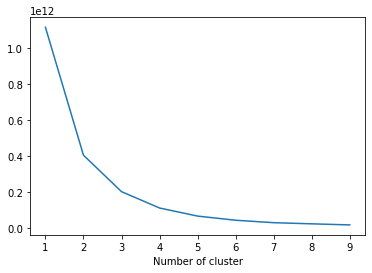

In [413]:
sse={}
# recency = online_recency[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(model_input)
#     model_input["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()

The elbow method shows that 4 clusters are the best option.

In [417]:
#creating 4 clusters
kmeans = KMeans(n_clusters=4, max_iter=1000)
# kmeans.fit_predict(model_input.iloc[:,1:])
model_input["clusters"] = kmeans.fit_predict(model_input)

#see details of the clusters
cluster_info = model_input.groupby('clusters')['Revenue'].describe()

In [418]:
cluster_info.sort_values('mean')

,count,mean,std,min,25%,50%,75%,max
clusters,,,,,,,,
0,5863.0,1838.925217,2890.511506,-25111.09,317.095,801.15,2060.4400,22228.88
3,66.0,43230.184591,22213.199638,22862.12,26365.845,33901.39,53225.7525,111739.36
1,8.0,195182.235000,62923.301710,124961.98,142827.530,179256.23,239982.3900,296063.44
2,2.0,546861.340000,33261.270611,523342.07,535101.705,546861.34,558620.9750,570380.61


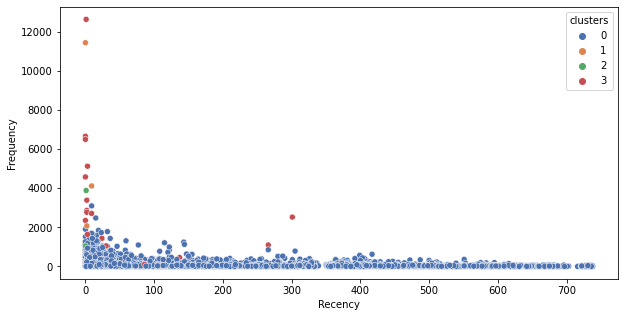

In [419]:
fig, ax = plt.subplots(1, 1, figsize=(10,5))
sns.scatterplot(x='Recency', y='Frequency', data=model_input,
               hue='clusters', palette="deep", ax=ax);
# ax.set_ylim(0, 8000)

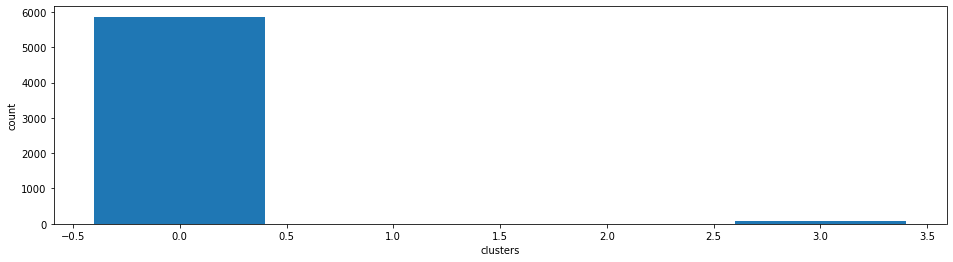

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(16,4))
ax.bar(cluster_info.index, cluster_info['count'])
ax.set_xlabel('clusters')
ax.set_ylabel('count');

Findings:
- Most of customers fall into clutster 0 and there is one cluster only including 2 customers.
- This clustering doesn't work well. It is possible caused by the skewed features. 

#### 5.1.2 StandardScaler<a id='5.1.2'></a>

In [421]:
model_input=model_input.drop(columns='clusters')

In [422]:
model_input.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000
mean,19.835088,18.512167,201.784812,134.334905,2742.884541
std,405.031023,83.275333,211.727459,348.092835,13679.955199
min,0.151333,-16.000000,0.000000,1.000000,-25111.090000
25%,2.323423,5.155944,24.000000,20.000000,321.365000
50%,3.010753,9.075472,95.000000,52.000000,823.530000
75%,3.962383,13.409903,380.000000,140.000000,2143.280000
max,25111.090000,3255.074627,738.000000,12638.000000,570380.610000


In [452]:
scl = StandardScaler()
model_input_std_scale = scl.fit_transform(model_input)
model_input_std_scale = pd.DataFrame(model_input_scale, columns=model_input.columns)
model_input_std_scale.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5.939000e+03,5.939000e+03,5.939000e+03,5.939000e+03,5.939000e+03
mean,-3.197803e-18,-3.284729e-17,-1.876855e-17,-3.064610e-18,1.109008e-17
std,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00
min,-4.860223e-02,-4.144694e-01,-9.531206e-01,-3.830763e-01,-2.036287e+00
25%,-4.323901e-02,-1.603998e-01,-8.397578e-01,-3.284886e-01,-1.770271e-01
50%,-4.154188e-02,-1.133288e-01,-5.043928e-01,-2.365514e-01,-1.403160e-01
75%,-3.919216e-02,-6.127497e-02,8.417906e-01,1.627604e-02,-4.383458e-02
max,6.195419e+01,3.886907e+01,2.532786e+00,3.592351e+01,4.149762e+01


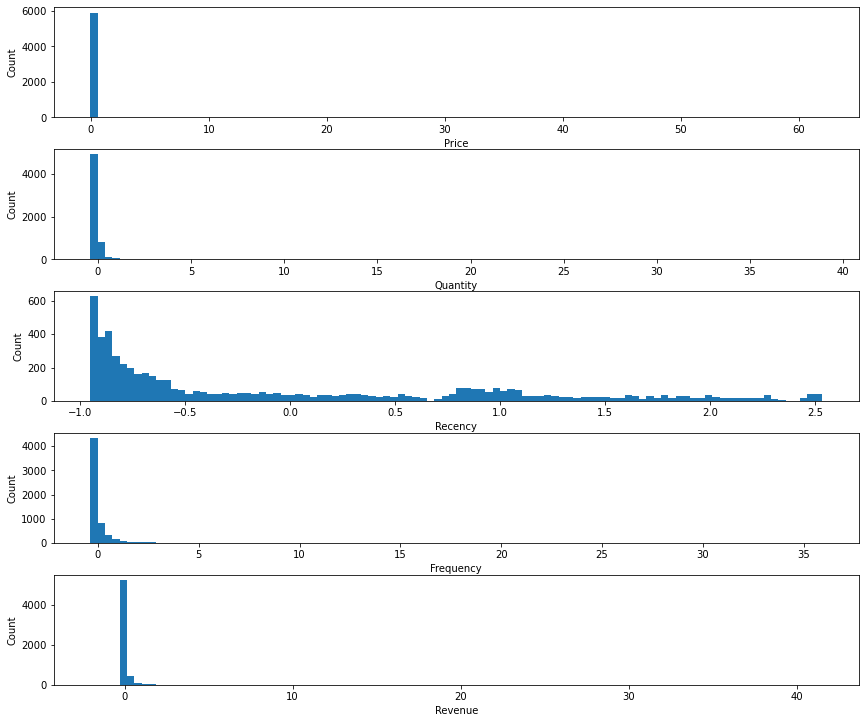

In [424]:
fig, ax = plt.subplots(5, 1, figsize=(12,10))
fig.tight_layout()

ax[0].hist(model_input_std_scale['Price'], bins=100)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Count')

ax[1].hist(model_input_std_scale['Quantity'], bins=100)
ax[1].set_xlabel('Quantity')
ax[1].set_ylabel('Count')

ax[2].hist(model_input_std_scale['Recency'], bins=100)
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Count')

ax[3].hist(model_input_std_scale['Frequency'], bins=100)
ax[3].set_xlabel('Frequency')
ax[3].set_ylabel('Count')

ax[4].hist(model_input_std_scale['Revenue'], bins=100)
ax[4].set_xlabel('Revenue')
ax[4].set_ylabel('Count')

plt.show();

- With standard scaler, the difference in the values of features is reduced but the distribution is not changes.

In [425]:
# Redo the clustering
kmeans = KMeans(n_clusters=4,tol=0.000001)
model_input_std_scale["clusters"] = kmeans.fit_predict(model_input_std_scale)

#see details of the clusters
cluster_info = model_input_scale.groupby('clusters')[['Recency', 'Frequency','Revenue']].describe()
cluster_info['Recency'].loc[:, ['count','mean']]

,count,mean
clusters,,
0,2536.0,-0.354291
1,95.0,-0.786706
2,2214.0,0.792235
3,1094.0,-0.713701


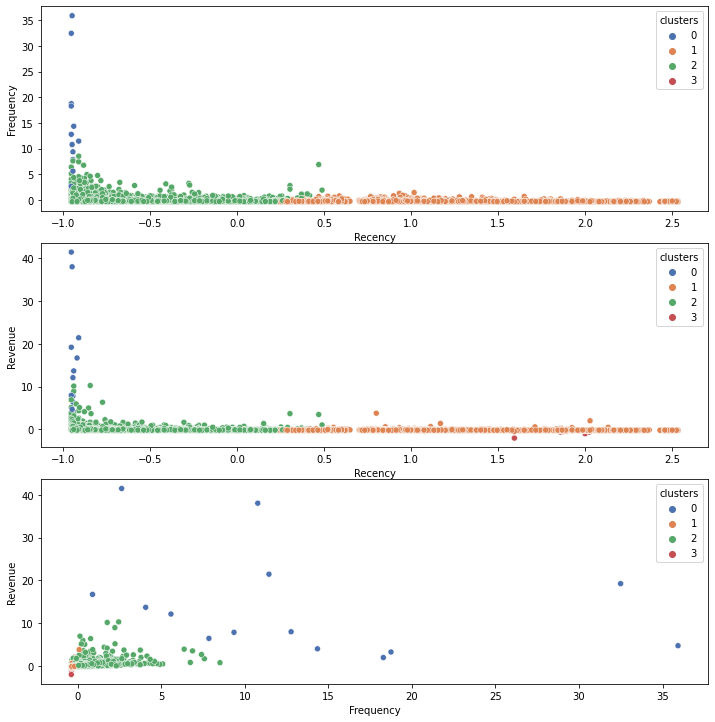

In [426]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
fig.tight_layout()

sns.scatterplot(x='Recency', y='Frequency', data=model_input_std_scale,
               hue='clusters', palette="deep", ax=ax[0]);
sns.scatterplot(x='Recency', y='Revenue', data=model_input_std_scale,
               hue='clusters', palette="deep", ax=ax[1]);
sns.scatterplot(x='Frequency', y='Revenue', data=model_input_std_scale,
               hue='clusters', palette="deep", ax=ax[2]);
plt.show()
# ax.set_ylim(0, 8000)

- The clulstering is improved.
- Recency's contribution is more significant compared to other features.

#### 5.1.3 Logarithmic + cubic root transformation<a id='5.1.3'></a>

In [427]:
model_input_lc_scale = model_input.copy()
model_input_lc_scale[['Price','Frequency']] = np.log(model_input[['Price','Frequency']])
model_input_lc_scale[['Quantity','Revenue']] = np.cbrt(model_input[['Quantity','Revenue']])
model_input_lc_scale['Recency'] = np.cbrt(model_input['Recency'])
model_input_lc_scale.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000
mean,1.165223,2.153537,4.897137,3.918763,10.458900
std,0.739563,0.960796,2.391420,1.465930,6.077647
min,-1.888270,-2.519842,0.000000,0.000000,-29.283424
25%,0.843042,1.727572,2.884499,2.995732,6.849615
50%,1.102190,2.085882,4.562903,3.951244,9.373313
75%,1.376846,2.375793,7.243156,4.941642,12.893168
max,10.131065,14.820186,9.036886,9.444463,82.931894


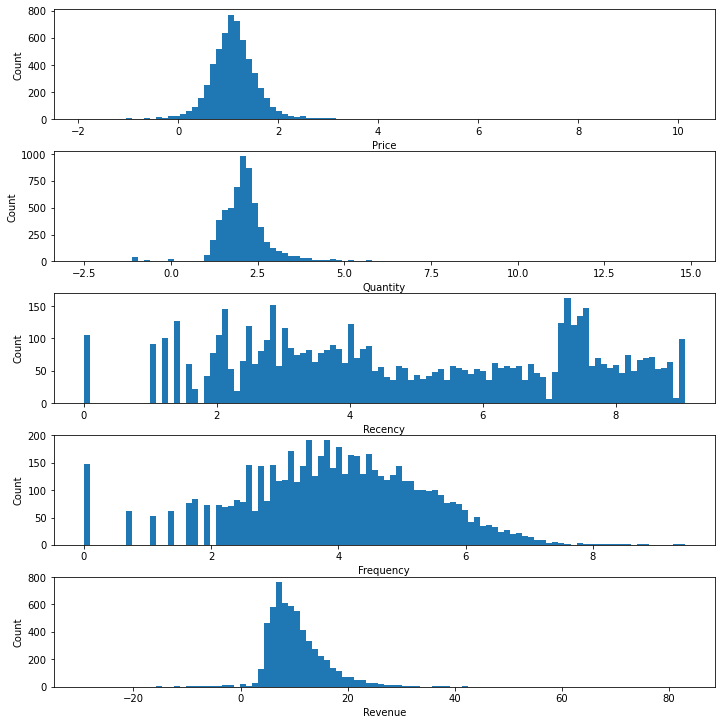

In [428]:
fig, ax = plt.subplots(5, 1, figsize=(10,10))
fig.tight_layout()

ax[0].hist(model_input_lc_scale['Price'], bins=100)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Count')

ax[1].hist(model_input_lc_scale['Quantity'], bins=100)
ax[1].set_xlabel('Quantity')
ax[1].set_ylabel('Count')

ax[2].hist(model_input_lc_scale['Recency'], bins=100)
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Count')

ax[3].hist(model_input_lc_scale['Frequency'], bins=100)
ax[3].set_xlabel('Frequency')
ax[3].set_ylabel('Count')

ax[4].hist(model_input_lc_scale['Revenue'], bins=100)
ax[4].set_xlabel('Revenue')
ax[4].set_ylabel('Count')

plt.show();

- Both the values and the distribution of features are changed.

In [431]:
# Redo the clustering
kmeans = KMeans(n_clusters=4,tol=0.000001)
model_input_lc_scale["clusters"] = kmeans.fit_predict(model_input_lc_scale)

#see details of the clusters
cluster_info = model_input_scale.groupby('clusters')[['Recency', 'Frequency','Revenue']].describe()
cluster_info['Recency'].loc[:, ['count','mean']]

,count,mean
clusters,,
0,2536.0,-0.354291
1,95.0,-0.786706
2,2214.0,0.792235
3,1094.0,-0.713701


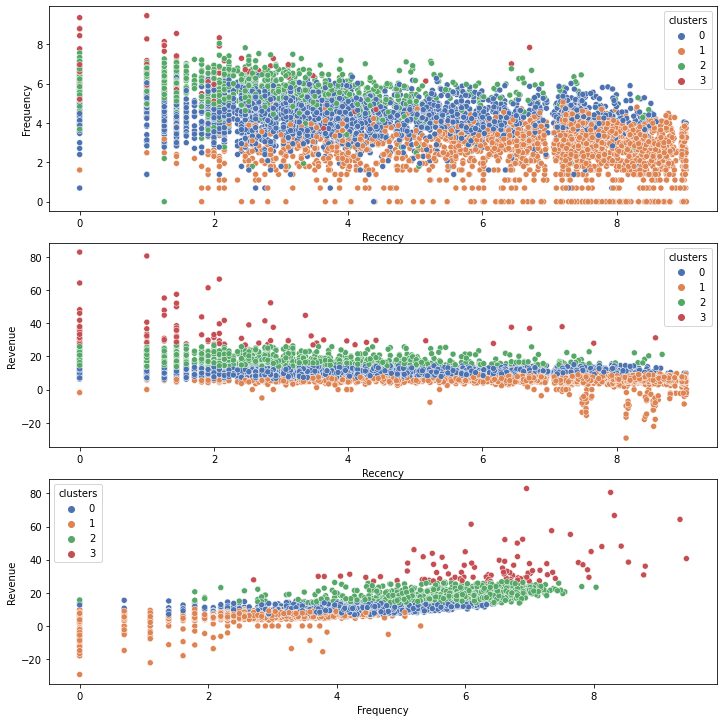

In [432]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
fig.tight_layout()

sns.scatterplot(x='Recency', y='Frequency', data=model_input_lc_scale,
               hue='clusters', palette="deep", ax=ax[0]);
sns.scatterplot(x='Recency', y='Revenue', data=model_input_lc_scale,
               hue='clusters', palette="deep", ax=ax[1]);
sns.scatterplot(x='Frequency', y='Revenue', data=model_input_lc_scale,
               hue='clusters', palette="deep", ax=ax[2]);
plt.show()
# ax.set_ylim(0, 8000)

#### 5.1.4 Logarithmic + cubic root transformation + StandardScaler<a id='5.1.4'></a>

In [433]:
model_input_lc_scale = model_input.copy()
model_input_lc_scale[['Price','Frequency']] = np.log(model_input[['Price','Frequency']])
model_input_lc_scale[['Quantity','Revenue']] = np.cbrt(model_input[['Quantity','Revenue']])
model_input_lc_scale['Recency'] = np.cbrt(model_input['Recency'])
model_input_lc_scale.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5939.000000,5939.000000,5939.000000,5939.000000,5939.000000
mean,1.165223,2.153537,4.897137,3.918763,10.458900
std,0.739563,0.960796,2.391420,1.465930,6.077647
min,-1.888270,-2.519842,0.000000,0.000000,-29.283424
25%,0.843042,1.727572,2.884499,2.995732,6.849615
50%,1.102190,2.085882,4.562903,3.951244,9.373313
75%,1.376846,2.375793,7.243156,4.941642,12.893168
max,10.131065,14.820186,9.036886,9.444463,82.931894


In [434]:
scl = StandardScaler()
model_input_std_lc_scale = scl.fit_transform(model_input_lc_scale)
model_input_std_lc_scale = pd.DataFrame(model_input_std_lc_scale, columns=model_input_lc_scale.columns)
model_input_std_lc_scale.describe()

,Price,Quantity,Recency,Frequency,Revenue
count,5.939000e+03,5.939000e+03,5.939000e+03,5.939000e+03,5.939000e+03
mean,1.221731e-16,-1.059376e-16,-2.044912e-16,-6.355882e-19,1.349690e-17
std,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00,1.000084e+00
min,-4.129130e+00,-4.864480e+00,-2.047967e+00,-2.673451e+00,-6.539648e+00
25%,-4.356743e-01,-4.433840e-01,-8.416786e-01,-6.297082e-01,-5.939122e-01
50%,-8.523724e-02,-7.042185e-02,-1.397758e-01,2.215897e-02,-1.786346e-01
75%,2.861694e-01,2.313437e-01,9.810976e-01,6.978269e-01,4.005617e-01
max,1.212419e+01,1.318460e+01,1.731229e+00,3.769733e+00,1.192552e+01


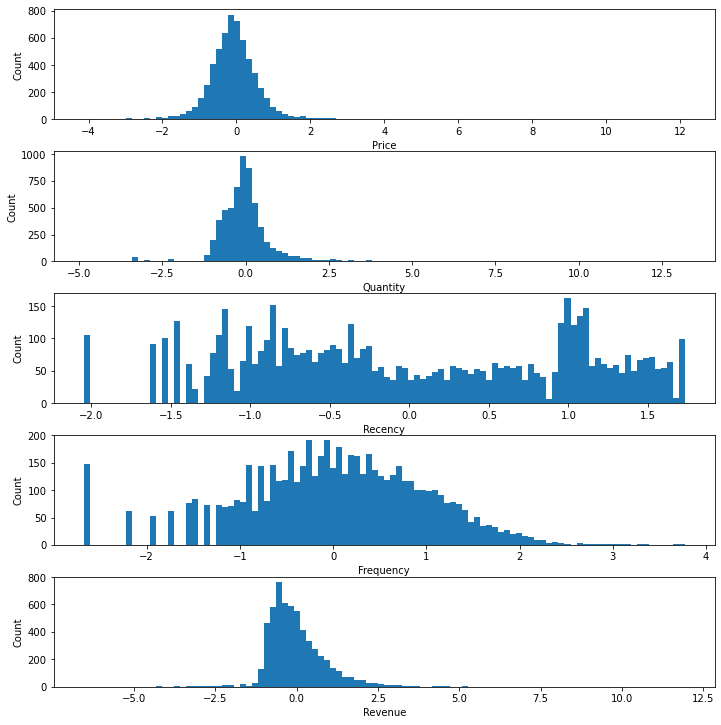

In [435]:
fig, ax = plt.subplots(5, 1, figsize=(10,10))
fig.tight_layout()

ax[0].hist(model_input_std_lc_scale['Price'], bins=100)
ax[0].set_xlabel('Price')
ax[0].set_ylabel('Count')

ax[1].hist(model_input_std_lc_scale['Quantity'], bins=100)
ax[1].set_xlabel('Quantity')
ax[1].set_ylabel('Count')

ax[2].hist(model_input_std_lc_scale['Recency'], bins=100)
ax[2].set_xlabel('Recency')
ax[2].set_ylabel('Count')

ax[3].hist(model_input_std_lc_scale['Frequency'], bins=100)
ax[3].set_xlabel('Frequency')
ax[3].set_ylabel('Count')

ax[4].hist(model_input_std_lc_scale['Revenue'], bins=100)
ax[4].set_xlabel('Revenue')
ax[4].set_ylabel('Count')

plt.show();

In [436]:
# Redo the clustering
kmeans = KMeans(n_clusters=4,tol=0.000001)
model_input_std_lc_scale["clusters"] = kmeans.fit_predict(model_input_std_lc_scale)

#see details of the clusters
cluster_info = model_input_std_lc_scale.groupby('clusters')[['Recency', 'Frequency','Revenue']].describe()
cluster_info['Recency'].loc[:, ['count','mean']]

,count,mean
clusters,,
0,2570.0,-0.822351
1,164.0,0.281140
2,88.0,1.291273
3,3117.0,0.626790


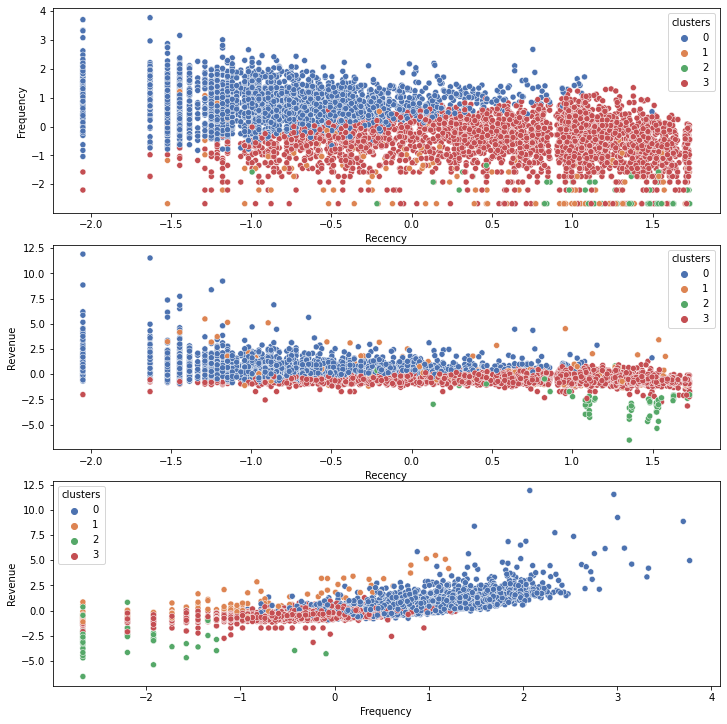

In [437]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
fig.tight_layout()

sns.scatterplot(x='Recency', y='Frequency', data=model_input_std_lc_scale,
               hue='clusters', palette="deep", ax=ax[0]);
sns.scatterplot(x='Recency', y='Revenue', data=model_input_std_lc_scale,
               hue='clusters', palette="deep", ax=ax[1]);
sns.scatterplot(x='Frequency', y='Revenue', data=model_input_std_lc_scale,
               hue='clusters', palette="deep", ax=ax[2]);
plt.show()
# ax.set_ylim(0, 8000)

### 5.2 DBSCAN<a id='5.2'></a>

In [453]:
model_input.head()

,Price,Quantity,Recency,Frequency,Revenue
0,12.074468,1.127660,325,47,-51.74
1,2.498063,13.364865,1,222,4921.53
2,3.786275,53.215686,74,51,2019.40
3,8.358833,8.994444,18,180,4404.54
4,3.841176,11.588235,309,17,334.40


In [476]:
clustering = DBSCAN(eps=1.1, min_samples=1).fit(model_input)
model_input["clusters"] = clustering.labels_

#see details of the clusters
cluster_info = model_input.groupby('clusters')[['Recency', 'Frequency','Revenue']].describe()
cluster_info['Recency'].loc[:, ['count','mean']]

,count,mean
clusters,,
0,1.0,325.0
1,1.0,1.0
2,1.0,74.0
3,1.0,18.0
4,1.0,309.0
...,...,...
5931,1.0,3.0
5932,1.0,429.0
5933,1.0,660.0


In [439]:
model_input_std_lc_scale = model_input_std_lc_scale.drop(columns='clusters')
model_input_std_lc_scale.head()

,Price,Quantity,Recency,Frequency,Revenue
0,1.792927,-1.158175,0.827280,-0.046811,-2.334189
1,-0.337670,0.228572,-1.629770,1.012353,1.077964
2,0.224691,1.673584,-0.292236,0.008912,0.358873
3,1.295599,-0.076903,-0.951981,0.869278,0.976309
4,0.244159,0.113873,0.779300,-0.740582,-0.578875


In [451]:
clustering = DBSCAN(eps=2, min_samples=5).fit(model_input_std_lc_scale)
model_input_std_lc_scale["clusters"] = clustering.labels_

#see details of the clusters
cluster_info = model_input_std_lc_scale.groupby('clusters')[['Recency', 'Frequency','Revenue']].describe()
cluster_info['Recency'].loc[:, ['count','mean']]

,count,mean
clusters,,
-1,53.0,0.242122
0,5787.0,-0.016140
1,67.0,1.436460
2,5.0,-1.342842
3,7.0,1.183116
4,8.0,-1.788575
5,7.0,0.435869
6,5.0,-1.197126


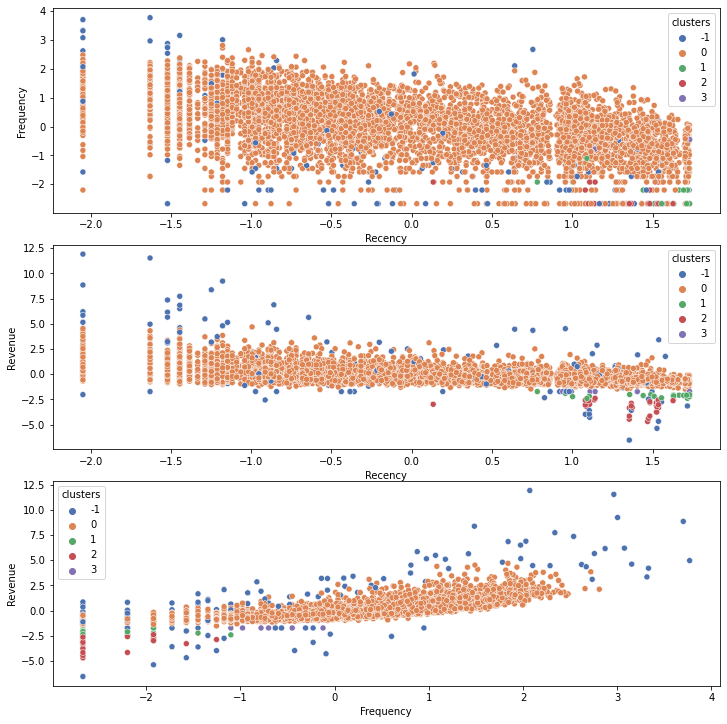

In [449]:
fig, ax = plt.subplots(3, 1, figsize=(10,10))
fig.tight_layout()

sns.scatterplot(x='Recency', y='Frequency', data=model_input_std_lc_scale,
               hue='clusters', palette="deep", ax=ax[0]);
sns.scatterplot(x='Recency', y='Revenue', data=model_input_std_lc_scale,
               hue='clusters', palette="deep", ax=ax[1]);
sns.scatterplot(x='Frequency', y='Revenue', data=model_input_std_lc_scale,
               hue='clusters', palette="deep", ax=ax[2]);
plt.show()
# ax.set_ylim(0, 8000)